In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

In [2]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
# from sklearn.preprocessing import MinMaxScaler

In [3]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [4]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than n_coll.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # Scale t
    scaler_t = MinMaxScaler()
    t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # Scale x
    scaler_x = MinMaxScaler()
    x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star

In [5]:
def get_data_unif_coll(n_coll_t, n_coll_x, n_obs, seed, data_for_pinn = False):  
    '''
    n_coll_t (int) : Integer less than 101.
    n_coll_x (int) : Integer less than 256.
    n_obs (int)    : Integet less than n_coll_t x n_coll_x.
    seed (int)     : Seed to choose data point set.
    '''  
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten())
    # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = jnp.real(data['x'].flatten())
    # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = jnp.real(data['usol'])

    # Fine meshgrid
    T, X = jnp.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = jnp.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    lb, ub = X_star.min(0), X_star.max(0)    
    # Fine u values
    u_star = Exact.flatten()[:,None]
    triplets_fine = jnp.hstack([X_star,u_star])


    # Triples at collocation point set
    idx_t_all = jnp.round(jnp.linspace(0, len(t) - 1, n_coll_t)).astype(int)
    t_all = t[idx_t_all]
    idx_x_all = jnp.round(jnp.linspace(0, len(x) - 1, n_coll_x)).astype(int)
    x_all = x[idx_x_all]
    # Collocation meshgrid
    T_all, X_all = jnp.meshgrid(t_all,x_all)
    # Collocation_pairs
    tx_all = np.hstack((T_all.flatten()[:,None], X_all.flatten()[:,None]))

    def is_in_array2(coords, array2):
        # Compare each coordinate pair to all rows in array2 and return True if it matches any row
        return jnp.any(jnp.all(coords == array2, axis=1))
    check_inclusion = jax.vmap(lambda row: is_in_array2(row[:2], tx_all))

    coords_to_check = triplets_fine[:,:2]
    triplets_all = triplets_fine[check_inclusion(coords_to_check)]

    # Collocation point set
    tx_all = triplets_all[:,:2]

    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_all, shape = (N_obs,), replace=False)
    triplets_train = triplets_obs[:int(N_obs*0.8),:]
    triplets_val = triplets_obs[int(N_obs*0.8):,:]

    # Data point set
    tx_train = triplets_train[:,:2]
    u_train = triplets_train[:,-1]

    # Validation point set
    tx_val = triplets_val[:,:2]
    u_val = triplets_val[:,-1]


    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])

    u_star = triplets_fine[:,-1]

    return tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star

We will compare `1.5 step` , `PINNSR` and  `SINDy` methods by using:

- Collocation point set: Randomly selected.
- Data point set: Randomly selected from Collocation point set.

by measuring the error of the recovered $u$ on the full given data.

We call the two functions `get_error_1_5` and `get_error_SINDy` in this notebook and later we upload the data resulting from `PINNSR` since they run on different Python environments.

In [6]:
def get_error_1_5(n_obs, n_coll_t,n_coll_x, run):
    
    tx_train, u_train, tx_val, u_val, tx_all, lb, ub, u_star, X_star = get_data_unif_coll(n_coll_t=n_coll_t,n_coll_x=n_coll_x,n_obs = n_obs,seed=run)
    
    # # if using val
    # tx_obs = jnp.vstack([tx_train,tx_val])
    # u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

    # if not using val
    tx_obs = tx_train
    u_obs  = u_train   

    # Run 1_5 step method

    u_operators = (eval_k,)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)
    
    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    # print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
        .reshape(
                len(tx_all),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)    
        
    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_all,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 100
    )

    # Optimize - LM
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        max_iter = 201,
        init_alpha=0.1,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,refine_convergence_data = SVD_LM(params,EqnModel,1e-3,50,overall_regularization=1e-12)
    # u_params
    u_sol = p_adjusted[:u_model.num_params]
    # u_true 
    u_true = u_star.flatten()
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_sol))
    
    return error_u_field

In [7]:
def get_error_SINDy(n_obs, n_coll_t, n_coll_x, run):
    tx_train, u_train, tx_val, u_val, tx_all, _, _, u_star, X_star = get_data_unif_coll(n_coll_t=n_coll_t,n_coll_x=n_coll_x,n_obs = n_obs,seed=run)
    
    # # if using val
    # tx_obs = jnp.vstack([tx_train,tx_val])
    # u_obs  = jnp.concatenate([u_train,u_val]).flatten()    

    # if not using val
    tx_obs = tx_train
    u_obs  = u_train

    # Run SINDy method

    u_operators = (eval_k,)
    feature_operators = (eval_k,dt_k,dx_k,dxx_k)

    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)

    k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(log1pexp(fitted_params)))

    # print(1/(jnp.sqrt(ML_lengthscales)))

    u_model = CholInducedRKHS(
        tx_obs,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )

    u_params = u_model.get_fitted_params(tx_obs,u_obs)

    # S = (
    #     (u_model.evaluate_operators(feature_operators,tx_all,u_params))
    #     .reshape(
    #             len(tx_all), 
    #             len(feature_operators),
    #             order = 'F'
    #         )
    # )

    # U_t = S[:,1]
    # UU_x = jnp.multiply(S[:,0],S[:,2])
    # U_xx = S[:,3]

    # Theta = jnp.vstack([UU_x, U_xx]).T
    
    # res = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)
    #print(f'SINDy recovered equation: u_t = {round(res[0][0],4)}uu_x + {round(res[1][0],4)}u_xx')
    
    # u_true 
    u_true = u_star.flatten()
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(X_star,u_params))
    
    return error_u_field

In [8]:
err = {
    '1_5_mthd': [],
    'SINDy':   []
}

In [9]:
# Run loop
NUM_RUNS = 5
N_OBS = [int(i) for i in jnp.arange(20,110,10)]
for n_obs in N_OBS:
    print("n_obs = ",n_obs)
    u_error_1_5 = []
    u_error_SINDy = []
    for run in range(NUM_RUNS):
        # Run
        res_1_5 = get_error_1_5(n_obs = n_obs,n_coll_t=31,n_coll_x=26,run=run)
        res_SINDy = get_error_SINDy(n_obs = n_obs,n_coll_t=31,n_coll_x=26,run=run)
        # Append
        u_error_1_5.append(res_1_5)
        u_error_SINDy.append(res_SINDy)
    # Append each list    
    err['1_5_mthd'].append(u_error_1_5)
    err['SINDy'].append(u_error_SINDy)   
    # Save after
    jnp.save('errors_comparisons/err_1_5_w_SINDy', err)

n_obs =  20


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 7.305e-05, Jres = 11.1, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 6.879e-05, Jres = 0.0989, alpha = 0.06944, improvement_ratio = 1.004
Iteration 2, loss = 6.755e-05, Jres = 0.01029, alpha = 0.05787, improvement_ratio = 1.007
Iteration 3, loss = 6.704e-05, Jres = 0.005708, alpha = 0.04823, improvement_ratio = 1.01
Iteration 4, loss = 6.677e-05, Jres = 0.003669, alpha = 0.04019, improvement_ratio = 1.012
Iteration 5, loss = 6.655e-05, Jres = 0.002005, alpha = 0.03349, improvement_ratio = 1.009
Iteration 100, loss = 2.649e-07, Jres = 0.004133, alpha = 8.333e-07, improvement_ratio = 0.9941
Iteration 200, loss = 1.353e-07, Jres = 2.341e-05, alpha = 8.333e-07, improvement_ratio = 0.9996


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.3497334550790553e-07


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 5.654e-05, Jres = 4.487, alpha = 0.08333, improvement_ratio = 0.9999
Iteration 1, loss = 5.528e-05, Jres = 0.0654, alpha = 0.06944, improvement_ratio = 1.002
Iteration 2, loss = 5.494e-05, Jres = 0.002762, alpha = 0.05787, improvement_ratio = 1.008
Iteration 3, loss = 5.475e-05, Jres = 0.0008469, alpha = 0.04823, improvement_ratio = 1.011
Iteration 4, loss = 5.46e-05, Jres = 0.0004935, alpha = 0.04019, improvement_ratio = 1.011
Iteration 5, loss = 5.446e-05, Jres = 0.0004057, alpha = 0.03349, improvement_ratio = 1.009
Iteration 100, loss = 3.144e-06, Jres = 0.01098, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 1.47e-06, Jres = 0.003477, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.4679780574280647e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 8.901e-05, Jres = 13.7, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 8.061e-05, Jres = 0.1395, alpha = 0.06944, improvement_ratio = 1.002
Iteration 2, loss = 7.899e-05, Jres = 0.01354, alpha = 0.05787, improvement_ratio = 1.003
Iteration 3, loss = 7.84e-05, Jres = 0.005495, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 7.801e-05, Jres = 0.002592, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 7.763e-05, Jres = 0.001157, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 1.259e-06, Jres = 0.0002406, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 9.141e-07, Jres = 1.29e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 9.133438225036793e-07


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001871, Jres = 8.909, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001365, Jres = 0.04721, alpha = 0.06944, improvement_ratio = 1.004
Iteration 2, loss = 0.0001205, Jres = 0.01596, alpha = 0.05787, improvement_ratio = 1.005
Iteration 3, loss = 0.000116, Jres = 0.01137, alpha = 0.04823, improvement_ratio = 1.009
Iteration 4, loss = 0.0001145, Jres = 0.005732, alpha = 0.04019, improvement_ratio = 1.013
Iteration 5, loss = 0.0001138, Jres = 0.002453, alpha = 0.03349, improvement_ratio = 1.012
Iteration 100, loss = 2.912e-07, Jres = 0.0005456, alpha = 8.333e-07, improvement_ratio = 0.9994
Iteration 200, loss = 1.166e-07, Jres = 1.773e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.1617136087901115e-07


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003054, Jres = 5.867, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.000265, Jres = 0.08758, alpha = 0.06944, improvement_ratio = 1.01
Iteration 2, loss = 0.0002583, Jres = 0.02736, alpha = 0.05787, improvement_ratio = 1.015
Iteration 3, loss = 0.0002539, Jres = 0.01429, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.0002493, Jres = 0.01108, alpha = 0.04019, improvement_ratio = 0.999
Iteration 5, loss = 0.000244, Jres = 0.01163, alpha = 0.03349, improvement_ratio = 0.998
Iteration 100, loss = 5.642e-06, Jres = 0.001744, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 4.825e-06, Jres = 0.0004741, alpha = 8.333e-07, improvement_ratio = 1.003


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 4.822738613377097e-06
n_obs =  30


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001169, Jres = 5.916, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001129, Jres = 0.05969, alpha = 0.06944, improvement_ratio = 1.001
Iteration 2, loss = 0.0001121, Jres = 0.00471, alpha = 0.05787, improvement_ratio = 1.003
Iteration 3, loss = 0.0001119, Jres = 0.001552, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0001118, Jres = 0.0006504, alpha = 0.04019, improvement_ratio = 1.006
Iteration 5, loss = 0.0001117, Jres = 0.000355, alpha = 0.03349, improvement_ratio = 1.004
Iteration 100, loss = 2.348e-06, Jres = 6.188e-05, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.825e-06, Jres = 1.468e-05, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.8234926013211343e-06
Iteration 40 Step Failed
Iteration 41 Step Failed
Iteration 47 Step Failed


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.01844, Jres = 16.8, alpha = 0.08333, improvement_ratio = 0.9655
Iteration 1, loss = 0.01732, Jres = 3.543, alpha = 0.06944, improvement_ratio = 1.009
Iteration 2, loss = 0.01676, Jres = 0.2471, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.01628, Jres = 0.2706, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.01581, Jres = 0.2094, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.01533, Jres = 0.1833, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 0.003015, Jres = 197.1, alpha = 3.281e-05, improvement_ratio = 0.4152
Iteration 200, loss = 0.002006, Jres = 746.5, alpha = 1.846e-05, improvement_ratio = 0.3049


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 0.0020054941397192323


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 2.926e-05, Jres = 3.75, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 2.038e-05, Jres = 0.05169, alpha = 0.06944, improvement_ratio = 1.0
Iteration 2, loss = 1.798e-05, Jres = 0.005961, alpha = 0.05787, improvement_ratio = 1.0
Iteration 3, loss = 1.733e-05, Jres = 0.002553, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 1.717e-05, Jres = 0.001169, alpha = 0.04019, improvement_ratio = 0.9999
Iteration 5, loss = 1.714e-05, Jres = 0.000499, alpha = 0.03349, improvement_ratio = 0.9998
Iteration 100, loss = 1.624e-06, Jres = 0.001759, alpha = 8.333e-07, improvement_ratio = 0.9995
Iteration 200, loss = 1.204e-06, Jres = 0.0008337, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.20345955300227e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 6.703e-05, Jres = 13.17, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 5.902e-05, Jres = 0.06598, alpha = 0.06944, improvement_ratio = 1.002
Iteration 2, loss = 5.713e-05, Jres = 0.008367, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 5.666e-05, Jres = 0.003072, alpha = 0.04823, improvement_ratio = 1.007
Iteration 4, loss = 5.651e-05, Jres = 0.001377, alpha = 0.04019, improvement_ratio = 1.01
Iteration 5, loss = 5.64e-05, Jres = 0.0009106, alpha = 0.03349, improvement_ratio = 1.006
Iteration 100, loss = 1.549e-06, Jres = 0.01888, alpha = 8.333e-07, improvement_ratio = 0.9864
Iteration 200, loss = 1.11e-06, Jres = 0.004285, alpha = 8.333e-07, improvement_ratio = 0.997


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.1089148845024945e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001221, Jres = 3.92, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.001207, Jres = 0.08974, alpha = 0.06944, improvement_ratio = 0.9983
Iteration 2, loss = 0.001198, Jres = 0.02228, alpha = 0.05787, improvement_ratio = 0.997
Iteration 3, loss = 0.00119, Jres = 0.02631, alpha = 0.04823, improvement_ratio = 0.9971
Iteration 4, loss = 0.001181, Jres = 0.02767, alpha = 0.04019, improvement_ratio = 0.9977
Iteration 5, loss = 0.001173, Jres = 0.02735, alpha = 0.03349, improvement_ratio = 0.9989
Iteration 100, loss = 0.0001124, Jres = 0.9259, alpha = 2.981e-06, improvement_ratio = 0.4778
Iteration 200, loss = 8.301e-05, Jres = 0.02915, alpha = 8.333e-07, improvement_ratio = 0.9981


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 8.29900827451266e-05
n_obs =  40


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002008, Jres = 1.528, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001873, Jres = 0.03248, alpha = 0.06944, improvement_ratio = 1.002
Iteration 2, loss = 0.0001806, Jres = 0.009016, alpha = 0.05787, improvement_ratio = 1.005
Iteration 3, loss = 0.0001774, Jres = 0.01679, alpha = 0.04823, improvement_ratio = 1.01
Iteration 4, loss = 0.0001758, Jres = 0.0169, alpha = 0.04019, improvement_ratio = 1.017
Iteration 5, loss = 0.0001751, Jres = 0.01322, alpha = 0.03349, improvement_ratio = 1.025
Iteration 100, loss = 7.444e-06, Jres = 0.8778, alpha = 5.681e-06, improvement_ratio = 0.8773
Iteration 200, loss = 1.11e-06, Jres = 0.1066, alpha = 8.333e-07, improvement_ratio = 0.8765


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.1073033272977343e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001491, Jres = 8.001, alpha = 0.08333, improvement_ratio = 0.9998
Iteration 1, loss = 0.000124, Jres = 0.05513, alpha = 0.06944, improvement_ratio = 0.9998
Iteration 2, loss = 0.0001164, Jres = 0.1262, alpha = 0.05787, improvement_ratio = 1.0
Iteration 3, loss = 0.0001137, Jres = 0.09131, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.0001125, Jres = 0.06212, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0001116, Jres = 0.04046, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 4.569e-06, Jres = 0.1907, alpha = 8.333e-07, improvement_ratio = 0.891
Iteration 200, loss = 2.167e-06, Jres = 0.0009845, alpha = 8.333e-07, improvement_ratio = 0.9999


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.1649769249166817e-06
Iteration 37 Step Failed


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001142, Jres = 24.9, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 9.342e-05, Jres = 0.07497, alpha = 0.06944, improvement_ratio = 1.0
Iteration 2, loss = 8.909e-05, Jres = 0.01097, alpha = 0.05787, improvement_ratio = 1.0
Iteration 3, loss = 8.809e-05, Jres = 0.004297, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 8.78e-05, Jres = 0.003524, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 8.762e-05, Jres = 0.002879, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 5.045e-06, Jres = 0.0004791, alpha = 8.333e-07, improvement_ratio = 0.9986
Iteration 200, loss = 3.064e-06, Jres = 0.001984, alpha = 8.333e-07, improvement_ratio = 0.9988


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 3.061600964378133e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005725, Jres = 12.41, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.000568, Jres = 0.09236, alpha = 0.06944, improvement_ratio = 0.9998
Iteration 2, loss = 0.0005666, Jres = 0.007319, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.0005656, Jres = 0.003966, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.0005646, Jres = 0.003346, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0005635, Jres = 0.002799, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 4.147e-05, Jres = 0.006873, alpha = 8.333e-07, improvement_ratio = 1.021
Iteration 200, loss = 2.323e-05, Jres = 0.0005815, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.3209156857067205e-05
Iteration 32 Step Failed
Iteration 37 Step Failed


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009933, Jres = 4.214, alpha = 0.08333, improvement_ratio = 0.9964
Iteration 1, loss = 0.0009457, Jres = 0.1584, alpha = 0.06944, improvement_ratio = 1.017
Iteration 2, loss = 0.0009353, Jres = 0.2547, alpha = 0.05787, improvement_ratio = 1.028
Iteration 3, loss = 0.000929, Jres = 0.1085, alpha = 0.04823, improvement_ratio = 1.017
Iteration 4, loss = 0.0009233, Jres = 0.05976, alpha = 0.04019, improvement_ratio = 1.01
Iteration 5, loss = 0.0009175, Jres = 0.04215, alpha = 0.03349, improvement_ratio = 1.007
Iteration 100, loss = 9.214e-05, Jres = 0.002891, alpha = 8.333e-07, improvement_ratio = 1.003
Iteration 200, loss = 7.453e-05, Jres = 0.003354, alpha = 8.333e-07, improvement_ratio = 1.005


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 7.450464533445175e-05
n_obs =  50


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003898, Jres = 7.685, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0003859, Jres = 0.05288, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0003847, Jres = 0.005858, alpha = 0.05787, improvement_ratio = 1.003
Iteration 3, loss = 0.000384, Jres = 0.00228, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.0003834, Jres = 0.001721, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0003828, Jres = 0.001537, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 2.711e-05, Jres = 0.001018, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 2.123e-05, Jres = 7.224e-05, alpha = 8.333e-07, improvement_ratio = 0.9999


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.122135108127193e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001691, Jres = 9.62, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001592, Jres = 0.0545, alpha = 0.06944, improvement_ratio = 0.9972
Iteration 2, loss = 0.0001568, Jres = 0.103, alpha = 0.05787, improvement_ratio = 0.9973
Iteration 3, loss = 0.0001553, Jres = 0.06331, alpha = 0.04823, improvement_ratio = 0.9995
Iteration 4, loss = 0.000154, Jres = 0.03783, alpha = 0.04019, improvement_ratio = 0.9999
Iteration 5, loss = 0.0001525, Jres = 0.02414, alpha = 0.03349, improvement_ratio = 0.9997
Iteration 100, loss = 2.678e-06, Jres = 0.004835, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.937e-06, Jres = 4.316e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.934930137715201e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001492, Jres = 3.17, alpha = 0.08333, improvement_ratio = 0.9926
Iteration 1, loss = 0.001455, Jres = 0.1183, alpha = 0.06944, improvement_ratio = 0.9988
Iteration 2, loss = 0.001442, Jres = 0.03217, alpha = 0.05787, improvement_ratio = 0.9996
Iteration 3, loss = 0.001435, Jres = 0.0202, alpha = 0.04823, improvement_ratio = 0.9982
Iteration 4, loss = 0.001429, Jres = 0.01253, alpha = 0.04019, improvement_ratio = 0.9983
Iteration 5, loss = 0.001422, Jres = 0.005925, alpha = 0.03349, improvement_ratio = 0.9991
Iteration 100, loss = 8.017e-05, Jres = 0.3661, alpha = 8.333e-07, improvement_ratio = 0.9606
Iteration 200, loss = 5.157e-05, Jres = 0.008178, alpha = 8.333e-07, improvement_ratio = 0.9997


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 5.1537584113644034e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003152, Jres = 3.744, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0003128, Jres = 0.07454, alpha = 0.06944, improvement_ratio = 1.012
Iteration 2, loss = 0.0003124, Jres = 0.004641, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 0.0003121, Jres = 0.001779, alpha = 0.04823, improvement_ratio = 1.001
Iteration 4, loss = 0.0003118, Jres = 0.001876, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0003115, Jres = 0.00197, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 1.573e-05, Jres = 0.00364, alpha = 8.333e-07, improvement_ratio = 1.009
Iteration 200, loss = 1.027e-05, Jres = 0.000527, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.0263205880061185e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007964, Jres = 12.29, alpha = 0.08333, improvement_ratio = 0.9995
Iteration 1, loss = 0.000788, Jres = 0.1316, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0007843, Jres = 0.02173, alpha = 0.05787, improvement_ratio = 1.008
Iteration 3, loss = 0.0007813, Jres = 0.01421, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0007783, Jres = 0.009323, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.0007751, Jres = 0.006972, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 7.541e-05, Jres = 0.03911, alpha = 8.333e-07, improvement_ratio = 1.004
Iteration 200, loss = 5.25e-05, Jres = 0.008738, alpha = 8.333e-07, improvement_ratio = 1.002


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 5.2468124067969155e-05
n_obs =  60


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005035, Jres = 12.7, alpha = 0.08333, improvement_ratio = 0.9994
Iteration 1, loss = 0.0003708, Jres = 0.2104, alpha = 0.06944, improvement_ratio = 1.011
Iteration 2, loss = 0.0003348, Jres = 0.4265, alpha = 0.05787, improvement_ratio = 1.015
Iteration 3, loss = 0.0003224, Jres = 0.2245, alpha = 0.04823, improvement_ratio = 1.02
Iteration 4, loss = 0.0003165, Jres = 0.1639, alpha = 0.04019, improvement_ratio = 1.02
Iteration 5, loss = 0.0003124, Jres = 0.1062, alpha = 0.03349, improvement_ratio = 1.014
Iteration 100, loss = 1.891e-05, Jres = 0.00143, alpha = 8.333e-07, improvement_ratio = 1.007
Iteration 200, loss = 9.561e-06, Jres = 0.0001576, alpha = 8.333e-07, improvement_ratio = 1.004


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 9.550759517985787e-06


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001023, Jres = 8.339, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0009932, Jres = 0.143, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.0009832, Jres = 0.235, alpha = 0.05787, improvement_ratio = 0.999
Iteration 3, loss = 0.0009766, Jres = 0.06647, alpha = 0.04823, improvement_ratio = 0.9999
Iteration 4, loss = 0.0009704, Jres = 0.01454, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0009639, Jres = 0.01428, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 2.675e-05, Jres = 0.001297, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.911e-05, Jres = 0.0001992, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.909522558017963e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006823, Jres = 9.421, alpha = 0.08333, improvement_ratio = 0.9996
Iteration 1, loss = 0.0006692, Jres = 0.08501, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0006667, Jres = 0.01097, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.0006659, Jres = 0.003862, alpha = 0.04823, improvement_ratio = 0.9966
Iteration 4, loss = 0.0006654, Jres = 0.002731, alpha = 0.04019, improvement_ratio = 0.9983
Iteration 5, loss = 0.000665, Jres = 0.002982, alpha = 0.03349, improvement_ratio = 1.0
Iteration 100, loss = 0.0001086, Jres = 4.418, alpha = 7.001e-06, improvement_ratio = 0.8539
Iteration 200, loss = 2.251e-05, Jres = 7.552, alpha = 1e-06, improvement_ratio = 0.7972


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.2499163012137726e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002875, Jres = 4.276, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0002862, Jres = 0.07846, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.0002859, Jres = 0.003233, alpha = 0.05787, improvement_ratio = 0.9999
Iteration 3, loss = 0.0002857, Jres = 0.0009616, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 0.0002854, Jres = 0.0009356, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0002851, Jres = 0.001003, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 2.667e-05, Jres = 0.0006519, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 2.367e-05, Jres = 0.0002178, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.366703571382625e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003969, Jres = 12.31, alpha = 0.08333, improvement_ratio = 0.9999
Iteration 1, loss = 0.0003838, Jres = 0.1141, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0003805, Jres = 0.02198, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 0.0003789, Jres = 0.01512, alpha = 0.04823, improvement_ratio = 1.003
Iteration 4, loss = 0.0003776, Jres = 0.005703, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0003762, Jres = 0.002224, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 1.745e-05, Jres = 0.002761, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.219e-05, Jres = 0.004681, alpha = 8.333e-07, improvement_ratio = 0.9988


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.2180139595548986e-05
n_obs =  70


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001547, Jres = 2.891, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001519, Jres = 0.04312, alpha = 0.06944, improvement_ratio = 1.01
Iteration 2, loss = 0.0001514, Jres = 0.005944, alpha = 0.05787, improvement_ratio = 1.007
Iteration 3, loss = 0.0001512, Jres = 0.001978, alpha = 0.04823, improvement_ratio = 1.003
Iteration 4, loss = 0.000151, Jres = 0.001139, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0001507, Jres = 0.000949, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 1.45e-05, Jres = 0.0006455, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.23e-05, Jres = 0.0001216, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.22933352238523e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001086, Jres = 4.58, alpha = 0.08333, improvement_ratio = 0.9999
Iteration 1, loss = 0.001064, Jres = 0.2046, alpha = 0.06944, improvement_ratio = 1.003
Iteration 2, loss = 0.001055, Jres = 0.06657, alpha = 0.05787, improvement_ratio = 1.013
Iteration 3, loss = 0.001046, Jres = 0.034, alpha = 0.04823, improvement_ratio = 1.014
Iteration 4, loss = 0.001037, Jres = 0.02552, alpha = 0.04019, improvement_ratio = 1.012
Iteration 5, loss = 0.001026, Jres = 0.02521, alpha = 0.03349, improvement_ratio = 1.011
Iteration 100, loss = 1.666e-05, Jres = 0.001034, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.161e-05, Jres = 4.674e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.1602338086149092e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0007317, Jres = 8.604, alpha = 0.08333, improvement_ratio = 0.9995
Iteration 1, loss = 0.0007251, Jres = 0.0702, alpha = 0.06944, improvement_ratio = 1.025
Iteration 2, loss = 0.0007237, Jres = 0.00906, alpha = 0.05787, improvement_ratio = 1.011
Iteration 3, loss = 0.0007231, Jres = 0.005675, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 0.0007225, Jres = 0.00482, alpha = 0.04019, improvement_ratio = 0.9996
Iteration 5, loss = 0.000722, Jres = 0.004463, alpha = 0.03349, improvement_ratio = 1.0
Iteration 100, loss = 2.427e-05, Jres = 0.007491, alpha = 8.333e-07, improvement_ratio = 0.9979
Iteration 200, loss = 1.99e-05, Jres = 0.0006837, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.9895756230583103e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002541, Jres = 5.833, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.000253, Jres = 0.09181, alpha = 0.06944, improvement_ratio = 1.003
Iteration 2, loss = 0.0002527, Jres = 0.003132, alpha = 0.05787, improvement_ratio = 0.9997
Iteration 3, loss = 0.0002524, Jres = 0.001006, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 0.000252, Jres = 0.001026, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.0002516, Jres = 0.001187, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 2.387e-05, Jres = 0.002998, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 1.982e-05, Jres = 0.0001661, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.9815629164974232e-05
Iteration 46 Step Failed
Iteration 47 Step Failed
Iteration 48 Step Failed
Iteration 49 Step Failed


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009934, Jres = 6.559, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0009684, Jres = 0.0762, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0009564, Jres = 0.02348, alpha = 0.05787, improvement_ratio = 1.007
Iteration 3, loss = 0.0009463, Jres = 0.01127, alpha = 0.04823, improvement_ratio = 1.005
Iteration 4, loss = 0.0009357, Jres = 0.009719, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0009239, Jres = 0.0108, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 2.278e-05, Jres = 0.0043, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.585e-05, Jres = 0.0003735, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.584056025205588e-05
n_obs =  80


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0001223, Jres = 2.681, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0001192, Jres = 0.0448, alpha = 0.06944, improvement_ratio = 1.011
Iteration 2, loss = 0.0001188, Jres = 0.005179, alpha = 0.05787, improvement_ratio = 1.011
Iteration 3, loss = 0.0001187, Jres = 0.001349, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.0001186, Jres = 0.0007372, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0001185, Jres = 0.0007171, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 1.631e-05, Jres = 0.0007137, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.503e-05, Jres = 0.000311, alpha = 8.333e-07, improvement_ratio = 1.002


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.5023722766279382e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006043, Jres = 14.8, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0005942, Jres = 0.1793, alpha = 0.06944, improvement_ratio = 1.008
Iteration 2, loss = 0.000586, Jres = 0.04888, alpha = 0.05787, improvement_ratio = 1.002
Iteration 3, loss = 0.0005772, Jres = 0.04111, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.0005675, Jres = 0.04211, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.0005567, Jres = 0.04433, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 1.958e-05, Jres = 0.0007344, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.407e-05, Jres = 0.0002074, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.4063250348105313e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0008166, Jres = 8.579, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0008118, Jres = 0.07077, alpha = 0.06944, improvement_ratio = 1.035
Iteration 2, loss = 0.0008097, Jres = 0.0452, alpha = 0.05787, improvement_ratio = 1.011
Iteration 3, loss = 0.0008079, Jres = 0.01608, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.0008063, Jres = 0.01304, alpha = 0.04019, improvement_ratio = 1.006
Iteration 5, loss = 0.0008046, Jres = 0.01304, alpha = 0.03349, improvement_ratio = 1.006
Iteration 100, loss = 2.498e-05, Jres = 0.08386, alpha = 8.333e-07, improvement_ratio = 0.9978
Iteration 200, loss = 1.932e-05, Jres = 0.004639, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.9313763861716873e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.000295, Jres = 5.611, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0002936, Jres = 0.08984, alpha = 0.06944, improvement_ratio = 1.0
Iteration 2, loss = 0.0002931, Jres = 0.003438, alpha = 0.05787, improvement_ratio = 1.0
Iteration 3, loss = 0.0002926, Jres = 0.001238, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 0.0002921, Jres = 0.001384, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.0002915, Jres = 0.001634, alpha = 0.03349, improvement_ratio = 1.0
Iteration 100, loss = 3.022e-05, Jres = 0.001107, alpha = 8.333e-07, improvement_ratio = 1.009
Iteration 200, loss = 2.32e-05, Jres = 9.475e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.3189420577265764e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003143, Jres = 8.781, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0003085, Jres = 0.1041, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.0003076, Jres = 0.008012, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.000307, Jres = 0.002345, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.0003064, Jres = 0.001126, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0003059, Jres = 0.0008411, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 3.379e-05, Jres = 0.0005146, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 2.544e-05, Jres = 0.0002087, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.5424341433922164e-05
n_obs =  90


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0002379, Jres = 11.94, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0002355, Jres = 0.115, alpha = 0.06944, improvement_ratio = 1.003
Iteration 2, loss = 0.0002344, Jres = 0.005127, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.0002332, Jres = 0.001376, alpha = 0.04823, improvement_ratio = 0.9997
Iteration 4, loss = 0.000232, Jres = 0.002505, alpha = 0.04019, improvement_ratio = 0.9996
Iteration 5, loss = 0.0002306, Jres = 0.002918, alpha = 0.03349, improvement_ratio = 0.9996
Iteration 100, loss = 1.678e-05, Jres = 0.001005, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 1.178e-05, Jres = 0.0002825, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.1777148480830886e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001263, Jres = 29.03, alpha = 0.08333, improvement_ratio = 0.9999
Iteration 1, loss = 0.001246, Jres = 0.1719, alpha = 0.06944, improvement_ratio = 0.9982
Iteration 2, loss = 0.001236, Jres = 0.0215, alpha = 0.05787, improvement_ratio = 1.001
Iteration 3, loss = 0.001226, Jres = 0.01361, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.001215, Jres = 0.01484, alpha = 0.04019, improvement_ratio = 1.003
Iteration 5, loss = 0.001202, Jres = 0.01717, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 3.358e-05, Jres = 0.002021, alpha = 8.333e-07, improvement_ratio = 1.001
Iteration 200, loss = 2.502e-05, Jres = 0.000694, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.5007203782575774e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.000834, Jres = 4.181, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0008284, Jres = 0.06508, alpha = 0.06944, improvement_ratio = 1.03
Iteration 2, loss = 0.000826, Jres = 0.01961, alpha = 0.05787, improvement_ratio = 1.011
Iteration 3, loss = 0.000824, Jres = 0.01252, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.0008221, Jres = 0.01116, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.0008205, Jres = 0.01066, alpha = 0.03349, improvement_ratio = 1.004
Iteration 100, loss = 0.0001678, Jres = 0.1181, alpha = 1e-06, improvement_ratio = 0.6785
Iteration 200, loss = 6.341e-05, Jres = 0.002241, alpha = 8.333e-07, improvement_ratio = 1.006


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 6.337843536286231e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0009332, Jres = 8.521, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0009296, Jres = 0.0885, alpha = 0.06944, improvement_ratio = 1.021
Iteration 2, loss = 0.0009274, Jres = 0.008514, alpha = 0.05787, improvement_ratio = 1.006
Iteration 3, loss = 0.0009254, Jres = 0.008447, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.0009237, Jres = 0.008484, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.0009223, Jres = 0.008254, alpha = 0.03349, improvement_ratio = 1.002
Iteration 100, loss = 7.214e-05, Jres = 0.001337, alpha = 8.333e-07, improvement_ratio = 0.9998
Iteration 200, loss = 6.056e-05, Jres = 0.0005653, alpha = 8.333e-07, improvement_ratio = 1.001


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 6.0546792215124846e-05
Iteration 37 Step Failed
Iteration 38 Step Failed
Iteration 39 Step Failed
Iteration 40 Step Failed
Iteration 41 Step Failed


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0003362, Jres = 10.97, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0003296, Jres = 0.1228, alpha = 0.06944, improvement_ratio = 1.006
Iteration 2, loss = 0.0003285, Jres = 0.009642, alpha = 0.05787, improvement_ratio = 1.008
Iteration 3, loss = 0.0003278, Jres = 0.003195, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.0003272, Jres = 0.001506, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0003265, Jres = 0.001045, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 2.799e-05, Jres = 0.0006016, alpha = 8.333e-07, improvement_ratio = 1.007
Iteration 200, loss = 2.235e-05, Jres = 0.0001223, alpha = 8.333e-07, improvement_ratio = 0.9999


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 2.233879616281597e-05
Iteration 42 Step Failed
Iteration 43 Step Failed
Iteration 44 Step Failed
Iteration 45 Step Failed
n_obs =  100


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001115, Jres = 50.68, alpha = 0.08333, improvement_ratio = 0.9995
Iteration 1, loss = 0.001093, Jres = 0.4762, alpha = 0.06944, improvement_ratio = 1.025
Iteration 2, loss = 0.001087, Jres = 0.1355, alpha = 0.05787, improvement_ratio = 1.016
Iteration 3, loss = 0.001081, Jres = 0.01864, alpha = 0.04823, improvement_ratio = 1.006
Iteration 4, loss = 0.001075, Jres = 0.03313, alpha = 0.04019, improvement_ratio = 1.004
Iteration 5, loss = 0.001069, Jres = 0.03685, alpha = 0.03349, improvement_ratio = 1.003
Iteration 100, loss = 2.419e-05, Jres = 0.0005671, alpha = 8.333e-07, improvement_ratio = 1.002
Iteration 200, loss = 1.486e-05, Jres = 8.31e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.4849747337763583e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.002387, Jres = 15.9, alpha = 0.08333, improvement_ratio = 0.9995
Iteration 1, loss = 0.002304, Jres = 0.2346, alpha = 0.06944, improvement_ratio = 1.012
Iteration 2, loss = 0.002256, Jres = 0.1719, alpha = 0.05787, improvement_ratio = 1.01
Iteration 3, loss = 0.00221, Jres = 0.1054, alpha = 0.04823, improvement_ratio = 1.01
Iteration 4, loss = 0.002159, Jres = 0.09319, alpha = 0.04019, improvement_ratio = 1.01
Iteration 5, loss = 0.002104, Jres = 0.1023, alpha = 0.03349, improvement_ratio = 1.012
Iteration 100, loss = 0.000115, Jres = 0.1587, alpha = 8.333e-07, improvement_ratio = 0.9765
Iteration 200, loss = 9.487e-05, Jres = 0.003344, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 9.484295422493801e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.001217, Jres = 3.251, alpha = 0.08333, improvement_ratio = 1.003
Iteration 1, loss = 0.001201, Jres = 0.1762, alpha = 0.06944, improvement_ratio = 1.031
Iteration 2, loss = 0.001195, Jres = 0.07178, alpha = 0.05787, improvement_ratio = 1.026
Iteration 3, loss = 0.00119, Jres = 0.04852, alpha = 0.04823, improvement_ratio = 1.015
Iteration 4, loss = 0.001186, Jres = 0.0402, alpha = 0.04019, improvement_ratio = 1.008
Iteration 5, loss = 0.001182, Jres = 0.03588, alpha = 0.03349, improvement_ratio = 1.005
Iteration 100, loss = 7.023e-05, Jres = 0.001621, alpha = 8.333e-07, improvement_ratio = 1.004
Iteration 200, loss = 3.23e-05, Jres = 0.0005031, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 3.2281873611346504e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0006324, Jres = 9.164, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.0006272, Jres = 0.1346, alpha = 0.06944, improvement_ratio = 1.017
Iteration 2, loss = 0.0006246, Jres = 0.01383, alpha = 0.05787, improvement_ratio = 1.005
Iteration 3, loss = 0.0006224, Jres = 0.009515, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.0006202, Jres = 0.009251, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0006181, Jres = 0.009609, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 5.458e-05, Jres = 0.0006533, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 4.691e-05, Jres = 8.534e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 4.6894936758729074e-05


  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.0005597, Jres = 4.851, alpha = 0.08333, improvement_ratio = 1.0
Iteration 1, loss = 0.0005567, Jres = 0.07775, alpha = 0.06944, improvement_ratio = 1.007
Iteration 2, loss = 0.0005549, Jres = 0.005742, alpha = 0.05787, improvement_ratio = 1.002
Iteration 3, loss = 0.0005528, Jres = 0.001797, alpha = 0.04823, improvement_ratio = 1.0
Iteration 4, loss = 0.0005506, Jres = 0.001844, alpha = 0.04019, improvement_ratio = 1.0
Iteration 5, loss = 0.000548, Jres = 0.001893, alpha = 0.03349, improvement_ratio = 1.0
Iteration 100, loss = 2.353e-05, Jres = 0.00126, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 1.92e-05, Jres = 3.85e-05, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0, loss = 1.9190422007161005e-05


In [10]:
err = jnp.load('errors_comparisons/err_1_5_w_SINDy.npy', allow_pickle=True).item()

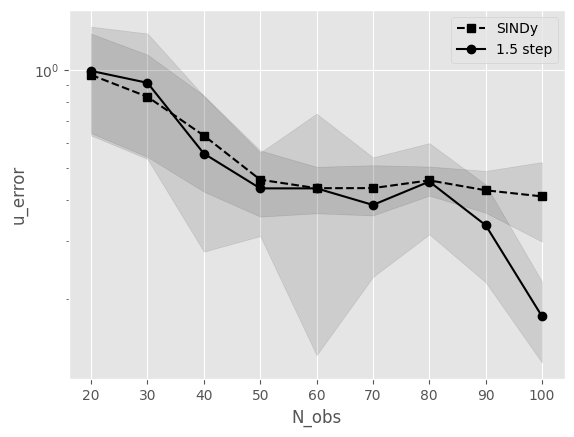

In [11]:
# Collocation points errors plot
# plt.title('Error vs. N | Burgers')
# Colors
c2 = 'black'
c1 = 'black'
# SINDy method plot
mean_SINDy = jnp.array([jnp.mean(e) for e in jnp.array(err['SINDy'])])
sd_SINDy = jnp.array([jnp.std(e) for e in jnp.array(err['SINDy'])])
# Plot 2 method
plt.plot(N_OBS, mean_SINDy, label = f'SINDy', marker= 's', color = c2,linestyle = 'dashed')
plt.fill_between(N_OBS, mean_SINDy - sd_SINDy, mean_SINDy + sd_SINDy, alpha=.1, color = c2)
plt.yscale('log')
# 1_5 step method plot

# 1_5 method
mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'])])
sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'])])
# Plot 1_5 method
plt.plot(N_OBS, mean_i_opt_1_5, label =  f'1.5 step', marker= 'o', color = c1)
plt.fill_between(N_OBS, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
plt.yscale('log')

plt.legend(loc = 'upper right')

plt.ylabel('u_error')
plt.xlabel('N_obs')
# # adding labels to the plotlines
# xvals_2step = [5]*4 + [7.5]
# xvals_1step = [6.5]+[7]*4
# xvals = xvals_2step + xvals_1step
# lines = plt.gca().get_lines()
# labelLines(lines, align=True, xvals = xvals)
# # add legend box
# legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
#                    Line2D([0], [0], color= c1, label='1.5-step')]
# plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()